<a href="https://colab.research.google.com/github/ammobam/Display_SensorData/blob/main/210727_%EB%82%98%EB%AC%B4%ED%94%8C%EB%9E%98%EB%8B%9B_%EB%94%94%EC%8A%A4%ED%94%8C%EB%A0%88%EC%9D%B4_%EC%84%BC%EC%84%9C%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 디스플레이 생산라인 센서 데이터 분석

## 주제 : 불량품에 영향을 주는 요인 찾기
- 결과 : "ㅇㅇ센서에서 ㅁㅁ면 불량품"
1. 주요 요인 피처 5개 추출
2. 불량품/양품 구분하는 모델도 찾아야 함


- 머신러닝 이용


In [1]:
# 데이터 불러오기
import pandas as pd
df_origin = pd.read_csv('/content/drive/MyDrive/나무플래닛/1. 데이터_디스플레이/factory_glass_2016.zip', encoding='cp949')
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8145 entries, 0 to 8144
Columns: 841 entries, dat...date.name. to R.Vac
dtypes: float64(834), int64(6), object(1)
memory usage: 52.3+ MB


In [2]:
# 컬럼명 리스트 만들기
col_origin = df_origin.columns
col_origin

Index(['dat...date.name.', 'LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101',
       'LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102',
       'LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103', 'LEHR.DRV.MTR..M4.1.SPD.1WSI40104',
       'LEHR.DRV.MTR..M4.2.SPD.1WSI40105', 'LEHR.DRV.MTR..M5.1.SPD.1WSI40106',
       'LEHR.DRV.MTR..M5.2.SPD.1WSI40107', 'LEHR.DRV.MTR..M6.1.SPD.1WSI40108',
       'LEHR.DRV.MTR..M6.2.SPD.1WSI40109',
       ...
       'ROLLDOWN.폐기.RIGHT.', '진공패드.폐기.RIGHT.', '폐기율...',
       'ROLLDOWN.진공패드.폐기율..LEFT.', 'ROLLDOWN.진공패드.폐기율..RIGHT.',
       'ROLLDOWN.진공패드.폐기율..전체.', 'L.RD', 'L.Vac', 'R.RD', 'R.Vac'],
      dtype='object', length=841)

In [3]:
# 컬럼명 확인
col_origin[:-10]

Index(['dat...date.name.', 'LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101',
       'LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102',
       'LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103', 'LEHR.DRV.MTR..M4.1.SPD.1WSI40104',
       'LEHR.DRV.MTR..M4.2.SPD.1WSI40105', 'LEHR.DRV.MTR..M5.1.SPD.1WSI40106',
       'LEHR.DRV.MTR..M5.2.SPD.1WSI40107', 'LEHR.DRV.MTR..M6.1.SPD.1WSI40108',
       'LEHR.DRV.MTR..M6.2.SPD.1WSI40109',
       ...
       'STD_U_L', 'STD_U_R', 'STD_L_L', 'STD_L_R', 'STD_GLS_L', 'STD_GLS_R',
       '투입.LEFT.', '투입.RIGHT.', 'ROLLDOWN.폐기.LEFT.', '진공패드.폐기.LEFT.'],
      dtype='object', length=831)

In [4]:
df_origin.iloc[:, -10:]
## 각 행은 하루에 생산한 디스플레이의 센서 데이터 ??

,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
0,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
1,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
3,0,0,4.96,10.29,0.00,4.96,0.000,0.103,0.000,0.000
4,0,0,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...
8140,14,0,8.72,3.06,14.43,8.72,0.000,0.031,0.144,0.000
8141,13,1,8.37,3.13,13.08,8.37,0.010,0.021,0.121,0.009
8142,11,3,7.49,2.56,12.73,7.49,0.017,0.009,0.100,0.027
8143,14,3,9.00,1.85,16.50,9.00,0.000,0.019,0.136,0.029


In [ ]:
# 컬럼이름을 리스트로 변환
name_list = col_origin.tolist()

name_list_10=[]
for name in name_list:
    name = str(name)[:10]
    name_list_10.append(name)
name_list_10

In [6]:
# 컬럼명(10글자)을 키, 각 컬럼의 인덱스를 값으로 하는 딕셔너리 생성
# 이렇게 하면 컬럼명 앞 10글자가 겹치는 컬럼의 인덱스를 모아 볼 수 있으므로
# 이름이 유사한 컬럼 집단의 개수, 각 집단에 속하는 컬럼의 수를 파악하기 쉬워짐

# 빈 딕셔너리 생성
name_dict = {}

# 인덱스, 컬럼이름에 대해 반복
for index, key in enumerate(name_list_10):
    
    # 만약 key가 딕셔너리에 없으면 키, 인덱스 생성
    if key not in name_dict:
        name_dict[key] = [index]
        # 딕셔너리에 넣을 때 int가 아닌 list로 넣어야 함
    # 만약 key가 딕셔너리에 있으면 인덱스 추가
    else :
        name_dict[key].append(index)

# 확인
name_dict
name_dict.keys()
#name_dict.items()

dict_keys(['dat...date', 'LIFT.OUT.R', 'LEHR.DRV.M', 'DRIVE.MOTO', 'X1WOS45101', 'X1WOS45102', 'X1WOS45103', 'X1WOS45104', 'X1WOS45105', 'X1WOS45106', 'X1WOS45107', 'X1WOS45108', 'X1WOS45109', 'X1WOS45110', 'DCS_Offset', 'DAMP.POSIT', 'DB.N2.SCRE', 'N2.TO.EA13', 'ROOF.HEATI', 'ATM.FLOW.S', 'SEC11.N2.1', 'SEC11.N2.H', 'cluster', 'ML.Speed', 'Ribbon.Spe', 'Gross.widt', 'Left.edge', 'Right.edge', 'UPPER.AB1.', 'LOWER.AB1.', 'UPPER.AB2.', 'LOWER.AB2.', 'UPPER.AB3.', 'LOWER.AB3.', 'UPPER.AB4.', 'LOWER.AB4.', 'UPPER.AB5.', 'LOWER.AB5.', 'UPPER.AB6.', 'LOWER.AB6.', 'UPPER.AB7.', 'LOWER.AB7.', 'UPPER.AB8.', 'LOWER.AB8.', 'UPPER.AB9.', 'LOWER.AB9.', 'UPPER.AB10', 'LOWER.AB10', 'UPPER.AB11', 'LOWER.AB11', 'UPPER.C1..', 'LOWER.C1..', 'UPPER.C2..', 'LOWER.C2..', 'UPPER.C3..', 'LOWER.C3..', 'UPPER.C4..', 'LOWER.C4..', 'UPPER.RET.', 'TMP.GLASS.', 'TMP.TIN..B', 'X.10.BAY.L', 'X.10.BAY.R', 'X.1.BAY.LE', 'X.1.BAY.RI', 'X.7.BAY.LE', 'X.7.BAY.RI', 'X.1.LEHR.S', 'X.1.LEHR.O', 'X.2.LEHR.S', 'X.2.LEHR.O', '

In [7]:
# 컬럼 집단의 수 : 246개
len(name_dict)

246

## 각 컬럼집단의 상관관계 확인

In [8]:
# 'ATM.FLOW.S' 로 시작하는 컬럼 간의 상관계수 확인하기
## 만약 이름이 유사한 컬럼 간 종속성이 높다면
## 해당 컬럼 집단에서 하나만 골라 대표로 하고 전체 데이터에 대해 상관계수를 확인할 것

# 'ATM.FLOW.S' 컬럼 인덱스 리스트
col_atm = name_dict['ATM.FLOW.S']

# 데이터에서 해당 컬럼만 추출하여 저장하기
df = df_origin.iloc[:, col_atm]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8145 entries, 0 to 8144
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ATM.FLOW.SECT.6.N2.H2.1FI33410.PV      8145 non-null   float64
 1   ATM.FLOW.SECT.7.N2.H2.1FI33412.PV      8145 non-null   float64
 2   ATM.FLOW.SECT.8.N2.H2.1FI33414.PV      8145 non-null   float64
 3   ATM.FLOW.SECT.9.N2.1FIC33415.PV        8145 non-null   float64
 4   ATM.FLOW.SECT.9.N2.H2.1FIC33416.PV     8145 non-null   float64
 5   ATM.FLOW.SECT.10.N2.H2.1FIC33418.PV    8145 non-null   float64
 6   ATM.FLOW.SECT.2.N2.1FI33401.PV         8145 non-null   float64
 7   ATM.FLOW.SECT.2.N2.H2.1FI33402.PV      8145 non-null   float64
 8   ATM.FLOW.SECT.3.N2.1FI33403.PV         8145 non-null   float64
 9   ATM.FLOW.SECT.3.N2.H2.1FI33404.PV      8145 non-null   float64
 10  ATM.FLOW.SECT.4.N2.1FI33405.PV         8145 non-null   float64
 11  ATM.

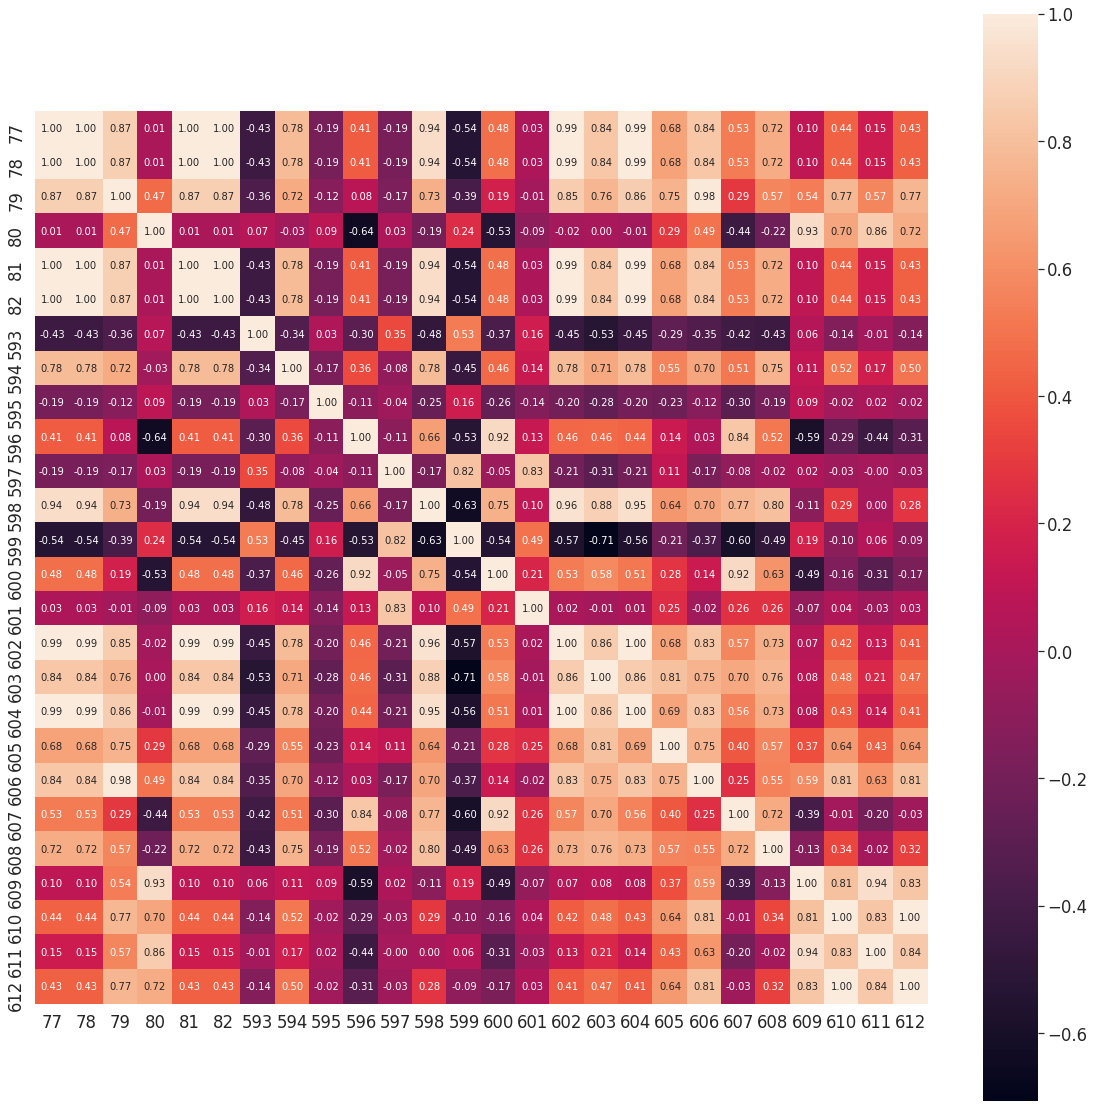

In [9]:
# 상관계수 데이터프레임을 배열로 저장
corr_array = df.corr().to_numpy()
#print(corr_array.shape)    # (26,26)

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.set(font_scale=1.5)
sns.heatmap(corr_array, cbar=True, square=True, fmt='.2f', annot=True,
           annot_kws={'size':10}, yticklabels=col_atm, xticklabels=col_atm)
plt.show()

### 중간결론
###'ATM.FLOW.S'로 시작하는 컬럼집단의 상관관계 확인 결과
- 'ATM.FLOW.S'
- 00, 500, 600 번대 센서데이터 있음
- 상관관계가 0.6 이상으로 높은 컬럼이 다수 존재함

### 종속성 높은 컬럼은 1개만 선택
- 상관관계 0.6 이상인 컬럼 중 1개만 선택함 (먼저 등장한 컬럼을 선택)

### 종속성 낮은 컬럼을 추림
- 상관관계 분석, 기술통계량 분석 수행

## 자동화
* 각 컬럼 집단 내 상관계수를 구하고
* 종속성 높은 컬럼은 1개만 선택
    * 상관관계 0.6 이상인 컬럼 중 1개만 선택함 (먼저 등장한 컬럼을 선택)

In [57]:
# 딕셔너리 키를 리스트로 저장
key_list = []
for key in name_dict.keys():
    key_list.append(key)
#key_list


[840]

In [58]:
# 상관계수 데이터프레임 생성 함수
# 키를 입력하면 해당 키에 속하는 컬럼간 상관계수 데이터프레임 생성
# 키 : 컬럼 집단명
def make_corr_df(key):
    # 컬럼 인덱스 리스트
    col_atm = name_dict[key]

    # 데이터에서 해당 컬럼만 추출하여 저장하기
    df_corr = df_origin.iloc[:, col_atm]
    df_corr = df_corr.corr()

    return df_corr


# 상관계수 시각화 함수
# 키를 입력하면 해당 키에 속하는 컬럼간 상관계수 히트맵 생성
def make_heatmap(key):
    
    # 컬럼 인덱스 리스트
    col_atm = name_dict[key]
    # 상관계수 데이터프레임 생성
    df_corr = make_corr_df(key)
    
    # 상관계수 데이터프레임을 배열로 저장
    corr_array = df_corr.to_numpy()

    # 상관계수 히트맵 그리기
    plt.figure(figsize=(14,14))
    sns.set(font_scale=1.5)
    sns.heatmap(corr_array, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size':10}, yticklabels=col_atm, xticklabels=col_atm)
    plt.show()

In [59]:
# make_corr 함수 확인
df_corr = make_corr_df('LIFT.OUT.R')
df_corr.describe()

,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101.1,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102.1,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103.1,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LIFT.OUT.ROL.MTR.M3.CUR.1WII40103.PV
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.614753,0.623108,0.619940,0.619920,0.620243,0.619855,0.232181,0.183958,0.239692
std,0.571516,0.559286,0.564187,0.564543,0.564025,0.564660,0.512143,0.555188,0.517058
min,-0.199014,-0.175137,-0.184396,-0.184831,-0.183871,-0.185148,-0.123036,-0.199014,-0.117913
25%,-0.117913,-0.093328,-0.102445,-0.104406,-0.103253,-0.104592,-0.107441,-0.184831,-0.104406
50%,0.991762,0.992003,0.992072,0.992003,0.991978,0.992020,-0.106352,-0.183871,-0.102445
75%,0.998529,0.998529,0.998961,0.999974,0.999974,0.999975,0.862103,0.862103,0.877254
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


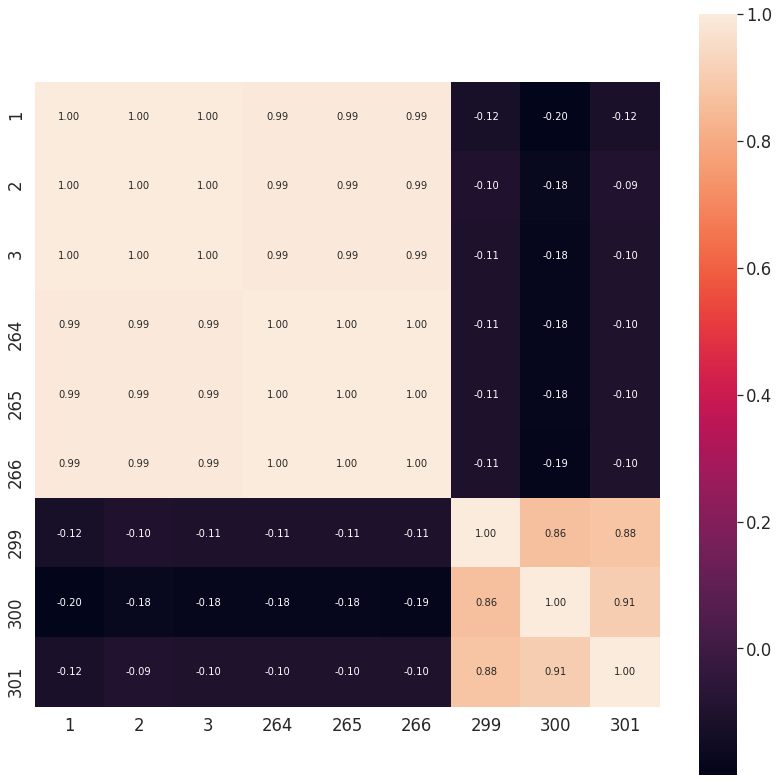

In [142]:
# make_heatmap 함수 확인
make_heatmap('LIFT.OUT.R')

In [155]:
# 각 컬럼집단(키) 내 컬럼간 상관계수를 구하고
df_corr = make_corr_df('LIFT.OUT.R')
#df_corr.describe()

# 상관계수의 절대값이 0.6 이상인 컬럼 중 1개만 선택함 (먼저 등장한 컬럼을 선택)
# 상관계수에 절대값 취함
df_abs = df_corr.abs()

# 데이터프레임의 한 줄을 시리즈로 저장
seri = df_abs.iloc[:, 0]

# 선택한 컬럼을 저장할 리스트 생성
col_select=[]

# 상관계수가 0.6 이하인 컬럼을 고르고, 해당 컬럼명을 리스트 저장
col_select.append(seri[seri<0.6].index)

# 상관계수가 0.6 이상인 컬럼 중 1개의 컬럼명을 리스트 저장
col_select.append(seri[seri>0.6].index[0])
col_select

[Index(['LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV',
        'LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV',
        'LIFT.OUT.ROL.MTR.M3.CUR.1WII40103.PV'],
       dtype='object'), 'LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101']